### 1. Importing packages

In [1]:
import pandas as pd
import numpy as np
import gc
import warnings
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")

### 2. Features creation

###### Loading initial data

In [2]:
path = 'C:/Users/AM000110/Desktop/ML/Kaggle/Instacart_Market_Basket_Analysis/input_data/'

In [ ]:
# Load Data ---------------------------------------------------------------

aisles = pd.read_csv(path + 'aisles.csv')
departments = pd.read_csv(path + 'departments.csv')
orderp = pd.read_csv(path + 'order_products__prior.csv')
ordert = pd.read_csv(path + 'order_products__train.csv')
orders = pd.read_csv(path + 'orders.csv')
products = pd.read_csv(path + 'products.csv')

###### Joining to product aisle and department names

In [ ]:
products = pd.merge(products, aisles, on='aisle_id')
products = pd.merge(products, departments, on='department_id')
products = products[['product_id', 'aisle_id', 'department_id']]

del aisles, departments
gc.collect()

###### Adding user_ids to order_train

In [ ]:
orders_users = orders[['order_id', 'user_id']]
orders_users = orders_users[orders_users['order_id'].isin(ordert.order_id.values)]
ordert = pd.merge(ordert, orders_users, on='order_id')

orders_users
gc.collect()

###### Joining orders data with prior data

In [ ]:
orders_products = pd.merge(orders, orderp, on='order_id')
orders_products = pd.merge(orders_products, products, on='product_id')

del orderp, products
gc.collect()

In [ ]:
f1_score = pd.read_csv('C:/Users/AM000110/Desktop/ML/Kaggle/Instacart_Market_Basket_Analysis/reordered_basket_size_prediction/f1_score.csv')
f1_score = f1_score[['order_id', 'average_f1_score']]

orders_products = pd.merge(orders_products, f1_score, on='order_id')
del f1_score
gc.collect()

###### Product general features

for each product:
* total number of orders (prod_orders)
* sum of reorders (prod_reorders)
* number of unique users who buy it (prod_first_orders)
* number of unque users who buy it more than 1 time (prod_second_orders)
* product reorder probability = prod_second_orders / prod_first_orders
* prod_reorder_times = 1 + prod_reorders / prod_first_orders
* prod_reorder_ratio = prod_reorders / prod_orders
* prod_average_order_hour_of_day (from me)
* prod_average_order_dow (from me)
* prod_frequency = prod_orders / total number of orders (from me)
* prod_reorder_frequency = prod_reorders / sum of total reorders (from me)
* prod_most_frequent_reoder_day (from me)
* product second reorder probability (from me)
* product aisle market share = aisle_orders / total_orders (from me)
* product deparment market share = department orders / total orders (from me)
* product market share in aisle = prod_orders / aisle_orders (from me)
* product market share in department = prod_orders / department_orders (from me)
* product order mean size (from me)
* product mean share within order (from me)
* product reorder std within users

In [ ]:
prd = pd.DataFrame()

In [ ]:
prd['prod_orders'] = orders_products.groupby('product_id')['order_id'].size()
prd['prod_reorders'] = orders_products.groupby('product_id')['reordered'].sum()
prd['prod_first_orders'] = orders_products.groupby('product_id')['user_id'].nunique()
prd['aisle_id'] = orders_products.groupby('product_id')['aisle_id'].min().astype(int)
prd['department_id'] = orders_products.groupby('product_id')['department_id'].min().astype(int)
prd['prod_average_order_hour_of_day'] = orders_products.groupby('product_id')['order_hour_of_day'].mean()
prd['prod_average_order_dow'] = orders_products.groupby('product_id')['order_dow'].mean()
prd['prod_period'] = orders_products.groupby('product_id')['days_since_prior_order'].sum()
prd['prod_average_f1_score'] = orders_products.groupby('product_id')['average_f1_score'].mean()
prd['prod_max_f1_score'] = orders_products.groupby('product_id')['average_f1_score'].max()
prd['prod_std_f1_score'] = orders_products.groupby('product_id')['average_f1_score'].std()
prd['prod_reoreder_mean_days'] = orders_products[orders_products.reordered > 0].groupby('product_id')['days_since_prior_order'].mean() 
prd['prod_reoreder_mean_hours'] = orders_products[orders_products.reordered > 0].groupby('product_id')['order_hour_of_day'].mean()
prd['prod_reoreder_mean_dow'] = orders_products[orders_products.reordered > 0].groupby('product_id')['order_dow'].mean()


In [ ]:
temp = pd.DataFrame(orders_products.groupby('product_id')['user_id'].value_counts())
temp.rename(columns={'user_id' : 'counts'}, inplace=True)
temp.reset_index(inplace=True)

prd['prod_second_orders'] = temp[temp['counts'] > 1].groupby('product_id')['counts'].size()
prd['prod_third_orders'] = temp[temp['counts'] > 2].groupby('product_id')['counts'].size()

del temp
gc.collect()

In [ ]:
prd['prod_reorder_probability'] = prd.prod_second_orders / prd.prod_first_orders
prd['prod_reorder_times'] = 1 + prd.prod_reorders / prd.prod_first_orders
prd['prod_reorder_ratio'] = prd.prod_reorders / prd.prod_orders
prd['prod_second_reorder_probability'] = prd.prod_third_orders / prd.prod_second_orders
prd['prod_frequency'] = prd.prod_orders / len(np.unique(orders_products.order_id.values))
prd['prod_reorder_frequency'] = prd.prod_reorders / orders_products.reordered.sum()

In [ ]:
temp = orders_products[orders_products['reordered'] != 0]
temp = pd.DataFrame(temp.groupby('product_id')['order_dow'].value_counts())
temp.rename(columns={'order_dow' : 'order_dow_counts'}, inplace=True)
temp.reset_index(inplace=True)
temp['max'] = temp.groupby(['product_id'])['order_dow_counts'].transform(max)
temp['dif'] = temp['max'] - temp['order_dow_counts']
temp = temp[temp['dif'] == 0]
temp = pd.DataFrame(temp.groupby('product_id')['order_dow'].min())
temp.rename(columns={'order_dow' : 'prod_most_frequent_reroder_order_dow'}, inplace=True)

prd = prd.join(temp)

del temp
gc.collect()

In [ ]:
temp = pd.DataFrame()
temp['aisle_orders'] = orders_products.groupby('aisle_id', as_index=False)['order_id'].size()
temp['prod_aisle_market_share'] = temp.aisle_orders / len(np.unique(orders_products.order_id.values))
temp.reset_index(inplace = True)
temp_temp = pd.DataFrame(orders_products.groupby('product_id')['aisle_id'].min())
temp_temp.reset_index(inplace=True)
temp_temp = temp_temp.merge(temp, on='aisle_id')

prd['prod_aisle_market_share']  = temp_temp.groupby('product_id')['prod_aisle_market_share'].min()
prd['prod_aisle_orders']  = temp_temp.groupby('product_id')['aisle_orders'].min()

del temp, temp_temp
gc.collect()

In [ ]:
temp = pd.DataFrame()
temp['department_orders'] = orders_products.groupby('department_id', as_index=False)['order_id'].size()
temp['prod_department_market_share'] = temp.department_orders / len(np.unique(orders_products.order_id.values))
temp.reset_index(inplace = True)
temp_temp = pd.DataFrame(orders_products.groupby('product_id')['department_id'].min())
temp_temp.reset_index(inplace=True)
temp_temp = temp_temp.merge(temp, on='department_id')

prd['prod_department_market_share']  = temp_temp.groupby('product_id')['prod_department_market_share'].min()
prd['prod_department_orders']  = temp_temp.groupby('product_id')['department_orders'].min()

del temp, temp_temp
gc.collect()

In [ ]:
prd['prod_market_share_in_aisle'] = prd.prod_orders / prd.prod_aisle_orders
prd['prod_market_share_in_department'] = prd.prod_orders / prd.prod_department_orders

In [ ]:
temp = pd.DataFrame(orders_products.groupby(['product_id', 'user_id'], as_index=False)['reordered'].sum())
temp = pd.DataFrame(temp.groupby(['product_id'])['reordered'].apply(list))

std_var = []
N = orders_products.user_id.nunique()
for row in temp.iterrows():
    all_users_data = row[1][0] + [0]*(N - len(row[1][0]))
    std_var.append((row[0], np.std(all_users_data), np.var(all_users_data)))

std_var = pd.DataFrame(std_var, columns=['product_id', 'prod_reorder_std', 'prod_reorder_var'])
prd['prod_reorder_std'] = std_var.groupby('product_id')['prod_reorder_std'].min()
prd['prod_reorder_variance'] = std_var.groupby('product_id')['prod_reorder_var'].min()

del temp, std_var
gc.collect()

In [ ]:
temp = pd.DataFrame(orders_products.groupby('order_id', as_index=False)['product_id'].size())
temp.columns = ['order_size']
temp['product_share'] = 1 / temp.order_size
temp.reset_index(inplace=True)

temp_temp = orders_products[['order_id', 'product_id']]
temp_temp = pd.merge(temp_temp, temp, on='order_id')

prd['prod_mean_order_size'] = temp_temp.groupby('product_id')['order_size'].mean()
prd['prod_mean_order_share'] = temp_temp.groupby('product_id')['product_share'].mean()

del temp, temp_temp
gc.collect()

In [ ]:
# prd.drop(['prod_reorders', 'prod_first_orders', 'prod_second_orders', 'prod_aisle_orders', 'prod_department_orders'], axis=1, inplace=True)

###### User general features

for each user:
* total number of orders (user_orders)
* sum of days_since_prior_order (user_period)
* mean of days_since_prior_order (user_mean_days_since_prior)
* total number of ordered products (user_total_products)
* user_reorder_ratio = sum(user_reordered_products) / (total number of products without first order)
* total number of ordered unique products (user_distinct_products)
* user max reorder rate (from me)
* user mean reorder rate (from me)
* user average reorder (from me)
* user average hour of order (from me)
* user average order dow (from me)


In [ ]:
users = pd.DataFrame()

In [ ]:
users['user_distinct_aisles'] = orders_products.groupby('user_id')['aisle_id'].nunique()
users['user_distinct_departments'] = orders_products.groupby('user_id')['department_id'].nunique()
users['user_average_order_hour_of_day'] = orders_products.groupby('user_id')['order_hour_of_day'].mean()
users['user_average_order_dow'] = orders_products.groupby('user_id')['order_dow'].mean()

users['user_average_f1_score'] = orders_products.groupby('user_id')['average_f1_score'].mean()
users['user_max_f1_score'] = orders_products.groupby('user_id')['average_f1_score'].max()
users['user_std_f1_score'] = orders_products.groupby('user_id')['average_f1_score'].std()
users['user_reoreder_mean_days'] = orders_products[orders_products.reordered > 0].groupby('user_id')['days_since_prior_order'].mean() 
users['user_reoreder_mean_hours'] = orders_products[orders_products.reordered > 0].groupby('user_id')['order_hour_of_day'].mean()
users['user_reoreder_mean_dow'] = orders_products[orders_products.reordered > 0].groupby('user_id')['order_dow'].mean()

users['user_reorder_distinct_products'] = orders_products[orders_products.reordered > 0].groupby('user_id')['product_id'].nunique()
users['user_reorder_distinct_aisles'] = orders_products[orders_products.reordered > 0].groupby('user_id')['aisle_id'].nunique()
users['user_reorder_distinct_departments'] = orders_products[orders_products.reordered > 0].groupby('user_id')['department_id'].nunique()


In [ ]:
temp = orders[orders['eval_set'] == 'prior']
users['user_orders'] = temp.groupby('user_id')['order_number'].max()
users['user_period'] = temp.groupby('user_id')['days_since_prior_order'].sum()
users['user_mean_days_since_prior'] = temp.groupby('user_id')['days_since_prior_order'].mean()

del temp
gc.collect()

In [ ]:
temp = pd.DataFrame(orders_products.groupby(['user_id', 'order_id'])['reordered'].sum())
temp.reset_index(inplace=True)

temp_products = pd.DataFrame(orders_products.groupby('order_id')['product_id'].apply(list))
temp_products.reset_index(inplace=True)
temp_products.columns = ['order_id', 'products_list']
temp_products['order_size'] = temp_products['products_list'].str.len() # defining order size
temp_products.drop(['products_list'], axis=1, inplace=True)

temp = pd.merge(temp, temp_products, on = 'order_id') 
temp['reorder_ratio'] = temp.reordered / temp.order_size

users['user_max_reorder_rate'] = temp.groupby('user_id')['reorder_ratio'].max()
users['user_mean_reorder_rate'] = temp.groupby('user_id')['reorder_ratio'].mean()
users['user_average_reorder'] = temp.groupby('user_id')['reordered'].mean()

del temp, temp_products
gc.collect()

In [ ]:
us = pd.DataFrame()
us['user_total_products'] = orders_products.groupby('user_id')['product_id'].size()
us['user_distinct_products'] = orders_products.groupby('user_id')['product_id'].nunique()

In [ ]:
temp = orders_products[orders_products['order_number'] > 1]
us['user_reorder_ratio'] = (orders_products.groupby('user_id')['reordered'].sum()
                           / temp.groupby('user_id')['product_id'].size())

del temp
gc.collect()

In [ ]:
users = users.join(us)
users['user_average_basket'] = users.user_total_products / users.user_orders

del us
gc.collect()

###### Joining test and train orders data

In [ ]:
temp = orders[orders['eval_set'] != 'prior'][['user_id', 'order_id', 'eval_set', 'days_since_prior_order', 'order_dow', 'order_hour_of_day']]  
temp.rename(columns={'days_since_prior_order' : 'time_since_last_order'}, inplace=True)
temp.set_index('user_id', inplace=True)

users = users.join(temp)

del temp
gc.collect()

###### Database for training

for each user + product pair:
* total number of orders by user ordered the product (up_orders)
* first order number of the product for user (up_first_order)
* last order number of the product for user (up_last_order)
* mean add_to_cart_order of product for user (up_average_cart_position)
* up_order_rate = up_orders / user_orders
* up_orders_since_last_order = user_orders - up_last_order
* up_order_rate_since_first_order = up_orders/(user_orders - up_first_order + 1)
* up_sum_cart_position (from me)
* up_reoreder_frequency (from me)
* up_porduct_score (form me)

In [ ]:
data = pd.DataFrame()

In [ ]:
data['up_orders'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].size()
data['up_first_order'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].min()
data['up_last_order'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].max()
data['up_average_cart_position'] = orders_products.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean()
data['up_sum_cart_position'] = orders_products.groupby(['user_id', 'product_id'])['add_to_cart_order'].sum()
data['up_product_period'] = orders_products.groupby(['user_id', 'product_id'])['days_since_prior_order'].sum()
data['up_product_sum_order_number'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].sum()
data['up_average_f1_scorer'] = orders_products.groupby(['user_id', 'product_id'])['average_f1_score'].mean()


In [ ]:
temp = pd.DataFrame(orders_products.groupby(['user_id', 'product_id'])['reordered'].sum())
temp['total_reordered'] = temp.groupby('user_id')['reordered'].transform(sum)
temp['up_reoreder_frequency'] = temp.reordered / temp.total_reordered
temp = temp[['up_reoreder_frequency']]
data = data.join(temp)

del temp
gc.collect()

In [ ]:
temp = orders_products[['user_id', 'product_id', 'order_number', 'reordered', 'days_since_prior_order', 'add_to_cart_order' ]]
temp.fillna(value=1, inplace=True)
temp['num_orders'] = temp.groupby(['user_id'])['order_number'].transform(max)
temp['days_since_prior_order'] = np.power(temp['days_since_prior_order'], 1/6)
temp['add_to_cart_order'] = np.power(temp['add_to_cart_order'], 1/6)
temp['up_product_score'] = (temp['reordered'] * temp['order_number'] * temp['days_since_prior_order']
                             / (temp['add_to_cart_order'] * temp['num_orders']))

data['up_product_score'] = temp.groupby(['user_id', 'product_id'])['up_product_score'].sum()

del temp
gc.collect()

In [ ]:
temp = pd.DataFrame(orders_products.groupby(['user_id'])['product_id'].size())
temp_temp = pd.DataFrame(orders_products.groupby(['user_id', 'product_id'])['order_id'].size())

temp.rename(columns={'product_id' : 'order_size'}, inplace=True)
temp_temp.reset_index(inplace=True)
temp.reset_index(inplace=True)
temp_temp = pd.merge(temp_temp, temp, on = 'user_id')
temp_temp['up_product_user_share'] = temp_temp.order_id / temp_temp.order_size

data['up_product_user_share'] = temp_temp.groupby(['user_id', 'product_id'])['up_product_user_share'].min()

del temp, temp_temp
gc.collect()

In [ ]:
del orders_products, orders
gc.collect()

###### Joining data with prd and users

In [ ]:
data.reset_index(inplace=True)
prd.reset_index(inplace=True)
users.reset_index(inplace=True)

In [ ]:
data = pd.merge(data, prd, on='product_id')

del prd
gc.collect()

data = pd.merge(data, users, on='user_id')

del users
gc.collect()

In [ ]:
data['up_order_rate'] = data.up_orders / data.user_orders
data['up_orders_since_last_order'] = data.user_orders - data.up_last_order
data['up_order_rate_since_first_order'] = data.up_orders / (data.user_orders - data.up_first_order + 1)
data['up_days_since_last_order'] = data.user_period - data.up_product_period
data['up_product_average_sum_order_numbers'] = data.up_product_sum_order_number / (data.user_orders * data.up_orders)

In [ ]:
del temp
gc.collect()

In [ ]:
data = pd.merge(data, ordert[['user_id', 'product_id', 'reordered']], how='left', on=['user_id', 'product_id'])

del ordert
gc.collect()

In [ ]:
data['prod_first_orders'] = data['prod_first_orders'].astype(np.int32)

###### Train and Test Datasets

In [ ]:
train = data[data['eval_set'] == 'train']
train = train.fillna(value=0)
train = train.drop(['eval_set'], axis=1)
train_columns = train.columns

test = data[data['eval_set'] == 'test']
test = test.drop(['eval_set', 'reordered'], axis=1)
test_columns = test.columns

del data
gc.collect()

###### Saving crated features

In [ ]:
np.savetxt(path + 'xgb_train_columns.csv', train_columns, delimiter=",", fmt='%s', header='')
np.savetxt(path + 'xgb_test_columns.csv', test_columns, delimiter=",", fmt='%s', header='')

np.save(path + 'xgb_train1', train)
np.save(path + 'xgb_test1', test)

### 3. Model

###### Loading saved train data

In [47]:
train_columns = pd.read_csv(path + 'xgb_train_columns.csv', header=None)
# train_dtypes = pd.read_csv(path + 'xgb_dtype_columns.csv', names=['column', 'dtype'], header=None)
# train = np.load(path + 'xgb_train1.npy', mmap_mode='r')

In [48]:
train_columns = train_columns.values.flatten()
# train = pd.DataFrame(train, columns = train_columns)

# del train_columns
# gc.collect()

In [25]:
f_to_use = pd.read_csv(path + 'xgb_initial_features.csv', header=None)
f_to_use = f_to_use.values.flatten()
# train = train[f_to_use]

In [50]:
train_columns = np.concatenate((train_columns, np.array(['user_mean_f1_average_basket'])))

###### Dividing into train and validation

###### a)

In [ ]:
train_orders = np.unique(train.order_id.values)
np.random.shuffle(train_orders)
valid_orders = train_orders[ : 75000]
train_orders = train_orders[75000 :]

In [ ]:
valid = train[train['order_id'].isin(valid_orders)]
train = train[train['order_id'].isin(train_orders)]
train.drop(['user_id', 'product_id', 'order_id'], axis=1, inplace=True)

In [ ]:
train_index = train.index.values
subtrain_size = 0.25
n = int(len(train_index) * subtrain_size)
np.random.shuffle(train_index)

t1_idx = train_index[: n]
t2_idx = train_index[n : 2*n]
t3_idx = train_index[2*n : 3*n]
t4_idx = train_index[3*n : ]

In [ ]:
train_1 = train.loc[t1_idx] 
train_2 = train.loc[t2_idx] 
train_3 = train.loc[t3_idx] 
train_4 = train.loc[t4_idx] 

train_labels_1 = train_1['reordered']
train_1 = train_1.drop('reordered', axis=1)

train_labels_2 = train_2['reordered']
train_2 = train_2.drop('reordered', axis=1)

train_labels_3 = train_3['reordered']
train_3 = train_3.drop('reordered', axis=1)

train_labels_4 = train_4['reordered']
train_4 = train_4.drop('reordered', axis=1)

valid_labels = valid[['user_id', 'order_id', 'product_id', 'reordered']]
valid.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis=1, inplace=True)

In [ ]:
del train, train_orders, valid_orders , train_index, t1_idx, t2_idx, t3_idx, t4_idx, 
gc.collect()

###### b)

In [26]:
train = train[train.user_average_basket < 7]

In [27]:
train['user_mean_f1_average_basket'] = train.user_average_f1_score * train.user_average_basket

In [28]:
train_orders = np.unique(train.order_id.values)
np.random.shuffle(train_orders)
# n = 117500
n = 20000

valid_orders = train_orders[ : n]
train_orders = train_orders[n : ]

In [29]:
valid_1 = train[train['order_id'].isin(valid_orders)]
valid_labels_1 = valid_1[['user_id', 'order_id', 'product_id', 'reordered']]
valid_1.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis=1, inplace = True)

train = train[train['order_id'].isin(train_orders)]
train_labels = train['reordered']
train.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis=1, inplace=True)

gc.collect()

7

* decreasing non reordereds

In [ ]:
print(train_labels.sum(), len(train_labels), train_labels.sum()/len(train_labels))

In [ ]:
reordered_index = train[train.reordered > 0].index.values
not_reordered_index = train[train.reordered == 0].index.values
not_reordered_index = np.random.choice(not_reordered_index, size = int(2*train.reordered.sum()), replace=False)
index = np.concatenate((reordered_index, not_reordered_index))

In [ ]:
train = train.loc[index]
train_labels = train['reordered']
train.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis=1, inplace=True)

###### c)

In [ ]:
train_index = train.index.values

subtrain_size = 0.1
n = int(len(train_index)* subtrain_size)
np.random.shuffle(train_index)

train_index = train_index[:n]

subtrain = train.loc[train_index] 
subtrain_labels = subtrain['reordered']
subtrain.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis=1, inplace=True

###### Model training

In [9]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.1.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xgb

In [10]:
params = {
  'objective'           : 'reg:logistic',
  'eval_metric"'        : 'logloss',
  'eta'                 : 0.1,
  'max_depth'           : 6,
  'min_child_weight'    : 10,
  'gamma'               : 0.70,
  'subsample'           : 0.77,
  'colsample_bytree'    : 0.95,
  'alpha'               : 2e-05,
  'lambda'              : 10
}

In [30]:
f_to_use = np.concatenate((f_to_use, np.array(['user_mean_f1_average_basket'])))

In [32]:
train_x = xgb.DMatrix(data = train[f_to_use[4:]], label = train_labels)
model_less_7 = xgb.train(params = params, dtrain = train_x, num_boost_round=90)

In [ ]:
model_less_7.eval(train_x)

In [12]:
model_more_7.eval(train_x)

'[0]\teval-rmse:0.264929'

In [ ]:
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(1,1,1)
xgb.plot_importance(model_less_7, height=0.2, ax=ax, importance_type='gain')

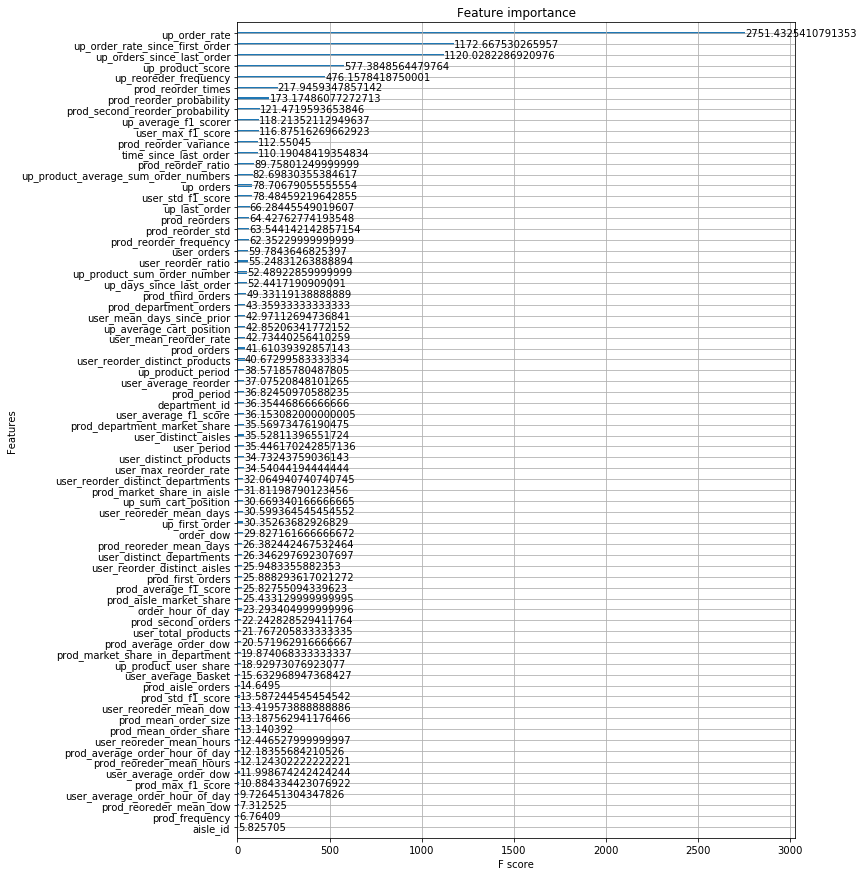

In [13]:
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(1,1,1)
xgb.plot_importance(model_more_7, height=0.2, ax=ax, importance_type='gain')

### Validation

In [15]:
valid_labels_1['prediction'] = model_more_7.predict(xgb.DMatrix(valid_1))

In [16]:
def fscore_data_generation(data, threshold):
    
    # true products
    temp = data[data['reordered'] > 0]
    validation_df = pd.DataFrame(temp.groupby(['user_id', 'order_id'], as_index=False)['product_id'].apply(list))

    del temp
    gc.collect()

    validation_df.rename(columns={0 : 'true_products'}, inplace=True)
    validation_df.reset_index(inplace=True)
    
    valid_orders = set(data['order_id'].values)
    predicted_orders = set(validation_df.order_id.values)
    none_orders = list(valid_orders - predicted_orders)
    none_products = ['None'] * len(none_orders)
    nones = data[data['order_id'].isin(none_orders)][['user_id', 'order_id']]
    nones.drop_duplicates(inplace=True)
    nones['true_products'] = none_products
    validation_df = pd.concat([validation_df, nones])
    
    # predicted products
    temp = data[data['prediction'] >= threshold]
    temp = pd.DataFrame(temp.groupby(['user_id', 'order_id'])['product_id'].apply(list))

    temp.rename(columns={'product_id' : 'predicted_products'}, inplace=True)
    temp.reset_index(inplace=True)
    
    predicted_orders = set(temp.order_id.values)
    none_orders = list(valid_orders - predicted_orders)
    none_products = ['None'] *len(none_orders)

    nones = data[data['order_id'].isin(none_orders)][['user_id', 'order_id']]
    nones.drop_duplicates(inplace=True)
    nones['predicted_products'] = none_products
    temp = pd.concat([temp, nones])
    temp.drop(['user_id'], axis=1, inplace=True)
    
    validation_df = pd.merge(validation_df, temp, on = 'order_id')

    del temp, none_orders, none_products, nones
    gc.collect()
    
    return validation_df

In [17]:
def f1_score(y_true, y_pred):
    
    y_true, y_pred = set(y_true), set(y_pred)
    p = sum([1 for i in y_pred if i in y_true]) / len(y_pred)
    r = sum([1 for i in y_true if i in y_pred]) / len(y_true)
    
    if p + r == 0:
        return 0
    return (2 * p * r) / (p + r)

In [18]:
def data_fscore(data):
    users_scores = []
    for row in data.iterrows():
        users_scores.append(f1_score(row[1][2], row[1][3]))
    data['f_score'] = users_scores
    return data

In [19]:
thresholds = [0.18, 0.19, 0.20, 0.21, 0.22]

In [21]:
scores = {}
for n in thresholds:
    validation_df = fscore_data_generation(valid_labels_1, n)
    fscore_data = data_fscore(validation_df)
    mean_fscore = fscore_data.f_score.mean()
    scores[n] = mean_fscore
    print(scores)

{0.18: 0.37906602928337946}
{0.18: 0.37906602928337946, 0.19: 0.3795533462906261}
{0.18: 0.37906602928337946, 0.19: 0.3795533462906261, 0.2: 0.37947039868944443}
{0.18: 0.37906602928337946, 0.19: 0.3795533462906261, 0.2: 0.37947039868944443, 0.21: 0.3784900144079188}
{0.18: 0.37906602928337946, 0.19: 0.3795533462906261, 0.2: 0.37947039868944443, 0.21: 0.3784900144079188, 0.22: 0.37712254671317075}


In [ ]:
plt.hist(fscore_data.f_score.values, bins=60)
plt.show()

###### Orders with low score

In [ ]:
low_score_users = fscore_data[fscore_data['f_score'] <= 0.1]['user_id'].values
low_score_labels = valid_labels[valid_labels['user_id'].isin(low_score_users)]

In [ ]:
low_score_thresholds = [0.07]

In [ ]:
scores = {}
for n in low_score_thresholds:
    low_fscore_data = data_fscore(fscore_data_generation(low_score_labels, n))
    mean_fscore = low_fscore_data.f_score.mean()
    scores[n] = mean_fscore
    print(scores)

In [ ]:
plt.hist(low_fscore_data.f_score.values, bins=60)
plt.show()

In [ ]:
idx = valid_labels[valid_labels.user_id.isin(low_score_users)].index.values
low_score_users_data = valid.loc[idx].join(valid_labels.loc[idx])

In [ ]:
high_score_users = list(set(valid_labels.user_id.values) - set(low_score_users))
idx = valid_labels[valid_labels.user_id.isin(high_score_users)].index.values
high_score_users_data = valid.loc[idx].join(valid_labels.loc[idx])

In [ ]:
fig = plt.figure(figsize=(10,4))
plt.hist(high_score_users_data.user_average_f1_score, bins=60)
plt.hist(low_score_users_data.user_average_f1_score, bins=60)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,4))
plt.hist(high_score_users_data.user_std_f1_score, bins=60)
plt.hist(low_score_users_data.user_std_f1_score, bins=60)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,4))
plt.hist(high_score_users_data.user_average_basket, bins=60)
plt.hist(low_score_users_data.user_average_basket, bins=60)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,4))
plt.hist(high_score_users_data.ffff, bins=60)
plt.hist(low_score_users_data.ffff, bins=60)
plt.show()

In [ ]:
del low_score_users_data, high_score_users_data
gc.collect()

### 4. Test Prediction

In [37]:
del validation_df
gc.collect()

7

In [38]:
test_columns = pd.read_csv(path + 'xgb_test_columns.csv', header=None)
test = np.load(path + 'xgb_test1.npy')

In [39]:
test_columns = test_columns.values.flatten()

test = pd.DataFrame(test, columns = test_columns)
test.fillna(value=0, inplace=True)

del test_columns
gc.collect()

10

In [40]:
test['user_mean_f1_average_basket'] = test.user_average_basket * test.user_average_f1_score

In [41]:
test_1 = test[test.user_average_basket >= 7]
test_2 = test[test.user_average_basket < 7]

del test
gc.collect()

7

In [53]:
train_columns[4:-1]

array(['up_orders', 'up_first_order', 'up_last_order',
       'up_average_cart_position', 'up_sum_cart_position',
       'up_product_period', 'up_product_sum_order_number',
       'up_average_f1_scorer', 'up_reoreder_frequency', 'up_product_score',
       'up_product_user_share', 'prod_orders', 'prod_reorders',
       'prod_first_orders', 'aisle_id', 'department_id',
       'prod_average_order_hour_of_day', 'prod_average_order_dow',
       'prod_period', 'prod_second_orders', 'prod_third_orders',
       'prod_reorder_probability', 'prod_reorder_times',
       'prod_reorder_ratio', 'prod_second_reorder_probability',
       'prod_frequency', 'prod_reorder_frequency',
       'prod_most_frequent_reroder_order_dow', 'prod_aisle_market_share',
       'prod_aisle_orders', 'prod_department_market_share',
       'prod_department_orders', 'prod_market_share_in_aisle',
       'prod_market_share_in_department', 'prod_reorder_std',
       'prod_reorder_variance', 'prod_mean_order_size',
       'pro

In [54]:
gc.collect()

211

In [55]:
test_1['reordered'] = model_more_7.predict(xgb.DMatrix(test_1[train_columns[4:-1]]))

# f_to_use = np.concatenate((f_to_use, np.array(['user_mean_f1_average_basket'])))
test_2['reordered'] = model_less_7.predict(xgb.DMatrix(test_2[f_to_use[4:]]))

In [ ]:
test['reordered'] = model.predict(xgb.DMatrix(test[list(train.columns.values)]))

### 5. Users classification

In [ ]:
user_features = ['user_orders','user_period', 'user_mean_days_since_prior', 'user_max_reorder_rate',                                         
                 'user_mean_reorder_rate', 'user_average_reorder', 'user_average_order_hour_of_day',
                 'user_average_order_dow', 'user_total_products', 'user_distinct_products', 
                 'user_reorder_ratio', 'user_average_basket', 'user_distinct_aisles', 
                 'user_distinct_departments', 'user_average_f1_score', 'user_max_f1_score', 'user_std_f1_score',
                 'user_reoreder_mean_days', 'user_reoreder_mean_hours', 'user_reoreder_mean_dow', 'user_reorder_distinct_products',
                 'user_reorder_distinct_aisles', 'user_reorder_distinct_departments', 
                ]

In [ ]:
user_features2 = ['user_orders','user_period', 'user_mean_reorder_rate', 'user_average_reorder', 'user_total_products', 'user_distinct_products', 
                 'user_reorder_ratio', 'user_average_basket', 'user_distinct_aisles', 
                 'user_average_f1_score', 'user_max_f1_score', 'user_std_f1_score',
                  'user_reorder_distinct_products',
                 'user_reorder_distinct_aisles', 'user_reorder_distinct_departments', 
                ]

In [ ]:
user_train_data = valid[user_features2]
user_train_data = user_train_data.join(valid_labels)
user_train_data.drop(['order_id', 'product_id', 'reordered', 'prediction'], axis=1, inplace=True)
user_train_data.drop_duplicates(inplace=True)

In [ ]:
user_labels = pd.DataFrame(low_score_users, columns=['user_id'])
user_labels['user_label'] = 1

temp = list(set(user_train_data.user_id.values.flatten()) - set(user_labels.user_id.values.flatten()))
temp = pd.DataFrame(temp, columns=['user_id'])
temp['user_label'] = 0
user_labels = pd.concat([user_labels, temp])

del temp
gc.collect()

In [ ]:
user_train_data = pd.merge(user_train_data, user_labels, on = 'user_id')

In [ ]:
index = user_train_data.index.values
np.random.shuffle(index)

train_index = index[: 60000]
valid_index = index[60000 : ]
user_train = user_train_data.loc[train_index]
user_valid = user_train_data.loc[valid_index]

user_train_labels = user_train['user_label']
user_train = user_train[user_features2]

user_valid_labels = user_valid[['user_id', 'user_label']]
user_valid = user_valid[user_features2]

In [ ]:
user_x = xgb.DMatrix(user_train, user_train_labels)
user_model = xgb.train(params=params, dtrain=user_x, num_boost_round=60)

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
xgb.plot_importance(user_model, height=0.2, ax=ax, importance_type='gain')

In [ ]:
user_valid_labels['prediction'] = user_model.predict(xgb.DMatrix(user_valid))

In [ ]:
true_label = user_valid_labels.user_label.values.flatten()
predicted_label = user_valid_labels.prediction.values.flatten()

In [ ]:
for t in np.arange(.1,.8,.03):
    cl =np.zeros_like(predicted_label)
    score = 0
    prec = 0
    rec = 0
    k = 0
    for index, item in enumerate(predicted_label):
        if item > t :
            cl[index] = 1
        if cl[index] == true_label[index] and cl[index] == 0:
            prec += 1
        if cl[index] == true_label[index] and cl[index] == 1:
            rec += 1
        if cl[index] == true_label[index]:
            score += 1
        if true_label[index] == 0:
            k += 1
            
    score, prec, rec = score / len(user_valid_labels), prec/k, rec/sum(true_label)
    print(t, score, prec, rec)    

In [ ]:
user_train_data['user_prediction'] = user_model.predict(xgb.DMatrix(user_train_data[user_features2]))
user_prediction = user_train_data[['user_id', 'user_prediction']]
valid_labels = pd.merge(valid_labels, user_prediction)

In [ ]:
ll = 0.6
b_idx = valid_labels[valid_labels.user_prediction >= ll].index.values
g_idx = valid_labels[valid_labels.user_prediction < ll].index.values

In [ ]:
score = data_fscore(validation_df).f_score.mean()

In [ ]:
len(b)

In [ ]:
b = fscore_data_generation(valid_labels.loc[b_idx], 0.1)
g = fscore_data_generation(valid_labels.loc[g_idx], 0.187)
f = pd.concat([g, b])
data_fscore(f).f_score.mean() - score

###### Test users classification

In [ ]:
test_users_test_data_x = xgb.DMatrix(test[user_features])
test['user_prediction'] = user_model.predict(test_users_test_data_x)

### 6. Submission

###### a) with user classification

In [ ]:
submission = test[['user_id', 'order_id', 'product_id', 'reordered', 'user_prediction']]
submission[['order_id', 'product_id']] = submission[['order_id', 'product_id']].astype(int)

In [ ]:
bad_users = np.unique(test[test.user_prediction > 0.58]['user_id'].values)
good_users = list(set(test.user_id.values.flatten())- set(bad_users))

In [ ]:
good_user_pred = submission[submission.user_id.isin(good_users)]
good_user_pred = good_user_pred.drop('user_id', axis=1)
good_user_pred = good_user_pred[good_user_pred['reordered'] >= 0.21]
good_user_pred = pd.DataFrame(good_user_pred.groupby('order_id')['product_id'].apply(list))

In [ ]:
bad_user_pred = submission[submission.user_id.isin(bad_users)]
bad_user_pred = bad_user_pred.drop('user_id', axis=1)
bad_user_pred = bad_user_pred[bad_user_pred['reordered'] >= 0.12]
bad_user_pred = pd.DataFrame(bad_user_pred.groupby('order_id')['product_id'].apply(list))

In [ ]:
final_sub = pd.concat([good_user_pred, bad_user_pred])

del good_user_pred, bad_user_pred, submission
gc.collect()

In [ ]:
test_orders = set(test['order_id'].values)
predicted_orders = set(final_sub.index.values)
none_orders = list(test_orders - predicted_orders)
none_products = ['None'] *len(none_orders)

In [ ]:
none_submission = pd.DataFrame(index=none_orders, data=none_products, columns=['product_id'])
final_sub = pd.concat([final_sub, none_submission])

final_sub.index.name = 'order_id'
final_sub.rename(columns = {'product_id' : 'products'}, inplace=True)

In [ ]:
final_sub.to_csv('C:/Users/AM000110/Desktop/ML/Kaggle/Instacart_Market_Basket_Analysis/models/xgb_newf_model2.csv')

###### b) without users classification

In [62]:
submission_1 = test_1[['order_id', 'product_id', 'reordered']]
submission_1 = submission_1[submission_1['reordered'] >= 0.21]
submission_1['order_id'] = submission_1['order_id'].astype(int)
submission_1['product_id'] = submission_1['product_id'].astype(int)
submission_1 = pd.DataFrame(submission_1.groupby('order_id')['product_id'].apply(list))

In [63]:
submission = test_2[['order_id', 'product_id', 'reordered']]
submission = submission[submission['reordered'] >= 0.23]
submission['order_id'] = submission['order_id'].astype(int)
submission['product_id'] = submission['product_id'].astype(int)
submission = pd.DataFrame(submission.groupby('order_id')['product_id'].apply(list))

In [64]:
submission = pd.concat([submission, submission_1])

In [65]:
test_orders = set(test_1['order_id'].values) | set(test_2['order_id'].values)
predicted_orders = set(submission.index.values)
none_orders = list(test_orders - predicted_orders)
none_products = ['None'] *len(none_orders)

In [66]:
none_submission = pd.DataFrame(index=none_orders, data=none_products, columns=['product_id'])
submission = pd.concat([submission, none_submission])

submission.index.name = 'order_id'
submission.rename(columns = {'product_id' : 'products'}, inplace=True)

In [67]:
submission.to_csv('C:/Users/AM000110/Desktop/ML/Kaggle/Instacart_Market_Basket_Analysis/models/xgb_newnewf_2.csv')

###### c) based on basket size

In [ ]:
reorder_size = pd.read_csv('C:/Users/AM000110/Desktop/ML/Kaggle/Instacart_Market_Basket_Analysis/reordered_basket_size_prediction/last_order_reorder_size.csv', index_col='order_id' )

In [ ]:
reorder_size.reset_index(inplace=True)
reorder_size.rename(columns={'reordered' : 'reorder_size'}, inplace=True)

In [ ]:
submission = submission.sort_values(by=['order_id', 'reordered'])

In [ ]:
submission = pd.merge(submission, reorder_size, on='order_id')

In [ ]:
submission = pd.DataFrame(submission.groupby(['order_id', 'reorder_size'], as_index=False)['product_id'].apply(list))

In [ ]:
valid.dtypes

In [ ]:
submission.reset_index(inplace=True)
submission.columns = ['order_id', 'reorder_size', 'product_list']

In [ ]:
sub = []
for order in np.unique(submission['order_id'].values):
    order_df = submission[submission['order_id'] == order]
    size = order_df.reorder_size.values[0]
    if size == 0:
        products = ['None']
    else:
        products = order_df['product_list'].values[0][-size:]
    sub.append((order, products))

In [ ]:
test_data = test.drop(['user_id', 'product_id', 'order_id', 'user_prediction'], axis=1)
test_data = xgb.DMatrix(test_data)
prediction = model.predict(test_data)

In [ ]:
# test['reordered'] = prediction
submission = test[['order_id', 'product_id', 'reordered']]
submission[['order_id', 'product_id']] = submission[['order_id', 'product_id']].astype(int)

In [ ]:
sub = pd.DataFrame(sub, columns=['order_id', 'products'])
sub.set_index('order_id',inplace=True)

In [ ]:
sub.to_csv('C:/Users/AM000110/Desktop/ML/Kaggle/Instacart_Market_Basket_Analysis/models/xgb_lo_rs.csv')